<a href="https://colab.research.google.com/github/dustoff06/Trout/blob/main/Complete_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
!pip install openpyxl
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

## Read Data

In [ ]:
file_path = "/content/drive/MyDrive/RainbowTrout_Growth_Data.xlsx"
env_data = pd.read_excel(file_path, sheet_name=1)
fish_data = pd.read_excel(file_path, sheet_name=2)

## Create Date/Time Variables

In [ ]:
fish_data['ReleaseDate'] = pd.to_datetime(fish_data['Release Trip'])
fish_data['RecoveryDate'] = pd.to_datetime(fish_data['Recovery Trip'])
# Extract month and year
fish_data['ReleaseMonth'] = fish_data['ReleaseDate'].dt.month
fish_data['ReleaseYear'] = fish_data['ReleaseDate'].dt.year
fish_data['RecoveryMonth'] = fish_data['RecoveryDate'].dt.month
fish_data['RecoveryYear'] = fish_data['RecoveryDate'].dt.year
#NOTE:  Time at Large and Days Between were identical!

## Drop Unneeded Variables

In [ ]:
fish_data = fish_data.drop(columns=['Recovery River Mile',
                                    'Weight at Recapture', 'Length_Growth',
                                    'ReleaseDate','RecoveryDate', 'Weight_Growth',
                                    'ReleaseMonth','ReleaseYear'])
fish_data = fish_data.rename(columns={
    'Forklength at Release': 'L1',
    'Forklength at Recapture': 'L2'
})
fish_data.head()

,Release Trip,Recovery Trip,Release River Mile,Time at Large,L1,L2,Weight at Release,RecoveryMonth,RecoveryYear
0,2012-04-19,2012-07-05,-4.15,77,337.0,334,378.0,7,2012
1,2012-04-19,2012-07-05,-4.15,77,330.0,329,322.0,7,2012
2,2012-04-19,2012-07-05,-4.15,77,344.0,348,373.0,7,2012
3,2012-04-19,2012-07-05,-4.15,77,284.0,287,198.0,7,2012
4,2012-04-19,2012-07-05,-3.73,77,93.0,119,6.6,7,2012


## Convert to Dummies

In [ ]:
# Get modal values before dummy creation

recovery_month_mode = fish_data['RecoveryMonth'].mode()[0]
recovery_year_mode = fish_data['RecoveryYear'].mode()[0]

# Create dummies
fish_data = pd.get_dummies(fish_data,
                           columns=[ 'RecoveryMonth', 'RecoveryYear'],
                           drop_first=False)

# Drop dummy columns corresponding to modes
fish_data.drop([
    f'RecoveryMonth_{recovery_month_mode}',
    f'RecoveryYear_{recovery_year_mode}'
], axis=1, inplace=True)

# Convert all dummy columns to integers (0/1)
dummy_cols = [col for col in fish_data.columns if
              col.startswith('RecoveryMonth_') or
              col.startswith('RecoveryYear_')]

fish_data[dummy_cols] = fish_data[dummy_cols].astype(int)

fish_data.head()

,Release Trip,Recovery Trip,Release River Mile,Time at Large,L1,L2,Weight at Release,RecoveryMonth_2,RecoveryMonth_3,RecoveryMonth_4,...,RecoveryMonth_12,RecoveryYear_2012,RecoveryYear_2013,RecoveryYear_2014,RecoveryYear_2015,RecoveryYear_2017,RecoveryYear_2018,RecoveryYear_2019,RecoveryYear_2020,RecoveryYear_2021
0,2012-04-19,2012-07-05,-4.15,77,337.0,334,378.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2012-04-19,2012-07-05,-4.15,77,330.0,329,322.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2012-04-19,2012-07-05,-4.15,77,344.0,348,373.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2012-04-19,2012-07-05,-4.15,77,284.0,287,198.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,2012-04-19,2012-07-05,-3.73,77,93.0,119,6.6,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Merge with Environmental Variables
(MODIFIED, Weighted Average Approach)

In [ ]:
# Function to merge environmental variables with fish data using weighted averages
def merge_environmental_data(fish_data, env_data, env_vars):
    """
    Merges environmental data with fish growth data using a weighted average approach.

    Parameters:
    - fish_data: DataFrame containing fish release and recovery dates
    - env_data: DataFrame containing environmental measurements over time intervals
    - env_vars: List of environmental variable names to merge

    Returns:
    - fish_data with added environmental variables
    """
    # First, ensure dates are in datetime format
    fish_data['Release Trip'] = pd.to_datetime(fish_data['Release Trip'])
    fish_data['Recovery Trip'] = pd.to_datetime(fish_data['Recovery Trip'])

    # Process env_data dates
    def parse_env_dates(interval):
        start_part, end_part = interval.split('-')
        start_date = pd.to_datetime(start_part + '-01', format='%b%y-%d')
        end_date = pd.to_datetime(end_part + '-01', format='%b%y-%d') + pd.DateOffset(months=1, days=-1)
        return start_date, end_date

    # Create start and end date columns
    env_data[['start_date', 'end_date']] = env_data['Trip Interval'].apply(lambda x: pd.Series(parse_env_dates(x)))

    # Initialize environmental variable columns in fish_data
    for var in env_vars:
        fish_data[var] = np.nan

    # Define the weighted average function
    def get_weighted_env_values(release_date, recovery_date):
        """
        Calculate weighted environmental values for a fish's time at large.

        Parameters:
        - release_date: Date the fish was released
        - recovery_date: Date the fish was recaptured

        Returns:
        - Dictionary with weighted average values for each environmental variable
        """
        # Find overlapping intervals
        overlaps = env_data[(env_data['end_date'] >= release_date) & (env_data['start_date'] <= recovery_date)]

        if len(overlaps) == 0:
            return {var: np.nan for var in env_vars}

        # Calculate total days fish was at large
        total_days = (recovery_date - release_date).days + 1
        if total_days <= 0:
            return {var: np.nan for var in env_vars}

        # Calculate weighted values for each variable
        weighted_values = {var: 0.0 for var in env_vars}

        for _, env_row in overlaps.iterrows():
            # Calculate overlap period
            overlap_start = max(release_date, env_row['start_date'])
            overlap_end = min(recovery_date, env_row['end_date'])
            overlap_days = (overlap_end - overlap_start).days + 1

            # Calculate weight
            weight = overlap_days / total_days

            # Add weighted values
            for var in env_vars:
                if pd.notna(env_row[var]):
                    weighted_values[var] += weight * env_row[var]

        return weighted_values

    # Apply the function to each row in fish_data
    print("Merging environmental data (this may take a moment)...")
    for idx, row in fish_data.iterrows():
        weighted_values = get_weighted_env_values(row['Release Trip'], row['Recovery Trip'])
        for var in env_vars:
            fish_data.loc[idx, var] = weighted_values[var]

    # Report success statistics
    match_counts = fish_data[env_vars].notna().sum()
    print(f"Environmental data merge complete.")
    print(f"Records with environmental data:\n{match_counts}")
    print(f"Success rate: {match_counts.mean() / len(fish_data) * 100:.1f}%")

    return fish_data

# Define environmental variables to merge
env_vars = ["Discharge", "Water Temperature", "Solar Insolation",
           "Soluble Reactive Phosphorous Concentration"]

# Apply the function to merge data
fish_data_with_env = merge_environmental_data(fish_data, env_data, env_vars)

Merging environmental data (this may take a moment)...
Environmental data merge complete.
Records with environmental data:
Discharge                                     9798
Water Temperature                             9798
Solar Insolation                              9798
Soluble Reactive Phosphorous Concentration    9798
dtype: int64
Success rate: 100.0%


## Look at Data

In [ ]:
fish_data.head()

,Release River Mile,Time at Large,L1,L2,Weight at Release,RecoveryMonth_2,RecoveryMonth_3,RecoveryMonth_4,RecoveryMonth_6,RecoveryMonth_7,...,RecoveryYear_2015,RecoveryYear_2017,RecoveryYear_2018,RecoveryYear_2019,RecoveryYear_2020,RecoveryYear_2021,Discharge,Water Temperature,Solar Insolation,Soluble Reactive Phosphorous Concentration
0,-4.15,77,337.0,334,378.0,0,0,0,0,1,...,0,0,0,0,0,0,11.333077,10.457692,57.471667,0.013637
1,-4.15,77,330.0,329,322.0,0,0,0,0,1,...,0,0,0,0,0,0,11.333077,10.457692,57.471667,0.013637
2,-4.15,77,344.0,348,373.0,0,0,0,0,1,...,0,0,0,0,0,0,11.333077,10.457692,57.471667,0.013637
3,-4.15,77,284.0,287,198.0,0,0,0,0,1,...,0,0,0,0,0,0,11.333077,10.457692,57.471667,0.013637
4,-3.73,77,93.0,119,6.6,0,0,0,0,1,...,0,0,0,0,0,0,11.333077,10.457692,57.471667,0.013637


## Drop Variables Used Solely for Merge

In [ ]:
fish_data = fish_data.drop(columns=['Release Trip', 'Recovery Trip'])

## Verify Structure

In [ ]:
# Convert all object columns to numeric
for col in fish_data.select_dtypes(include='object').columns:
    fish_data[col] = pd.to_numeric(fish_data[col], errors='coerce')


## Identify Extreme Outliers


In [ ]:
#Clean Copy of DF
fish_model_data = fish_data.copy()

# Calculate Q1, Q3, and IQR
Q1 = fish_model_data['L2'].quantile(0.25)
Q3 = fish_model_data['L2'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds (using 3x IQR)
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Identify outliers
outliers = fish_model_data[(fish_model_data['L2'] < lower_bound) |
                           (fish_model_data['L2'] > upper_bound)]

# Display outliers
print(f"Outliers detected: {len(outliers)}")
print(outliers[['L2']])

Outliers detected: 0
Empty DataFrame
Columns: [L2]
Index: []


## Describe

In [ ]:
fish_data.describe()

,Release River Mile,Time at Large,L1,L2,Weight at Release,ReleaseMonth_1,ReleaseMonth_2,ReleaseMonth_3,ReleaseMonth_4,ReleaseMonth_6,...,RecoveryYear_2015,RecoveryYear_2017,RecoveryYear_2018,RecoveryYear_2019,RecoveryYear_2020,RecoveryYear_2021,Discharge,Water Temperature,Solar Insolation,Soluble Reactive Phosphorous Concentration
count,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,...,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000
mean,-3.739583,243.473158,187.260247,218.919882,118.776250,0.167279,0.022454,0.023474,0.142784,0.142172,...,0.124617,0.121862,0.121760,0.121249,0.088181,0.097775,18.647598,16.854979,50.238615,0.007315
std,0.688336,285.592323,87.532780,85.793041,132.940095,0.373244,0.148161,0.151412,0.349871,0.349244,...,0.330301,0.327143,0.327025,0.326433,0.283573,0.297025,4.136095,3.890000,17.864233,0.002865
min,-14.890000,28.000000,70.000000,74.000000,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.333077,8.653800,19.177447,0.002143
25%,-4.150000,74.000000,106.000000,136.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.991613,14.440826,37.754671,0.004891
50%,-3.750000,130.500000,163.000000,230.000000,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.811301,16.046806,49.711316,0.007313
75%,-3.340000,288.000000,267.000000,293.000000,197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.747055,19.168590,59.840120,0.009490
max,-1.960000,2256.000000,457.000000,472.000000,1182.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,32.112907,27.140667,105.919767,0.017423


## Boxplot of Dependent Variable

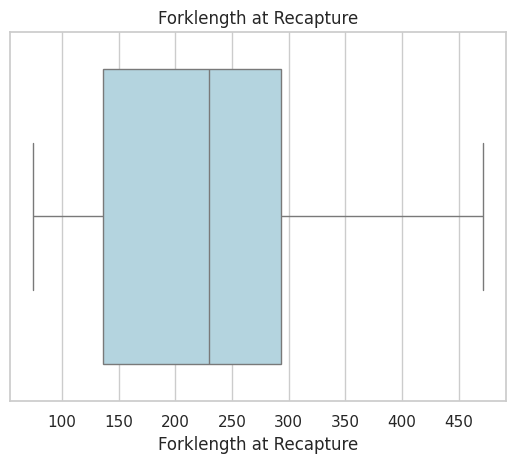

In [ ]:
sns.boxplot(x=fish_model_data['L2'], color='lightblue')
plt.xlabel('Forklength at Recapture')
plt.title('Forklength at Recapture')
plt.show()

## Correlation Analysis

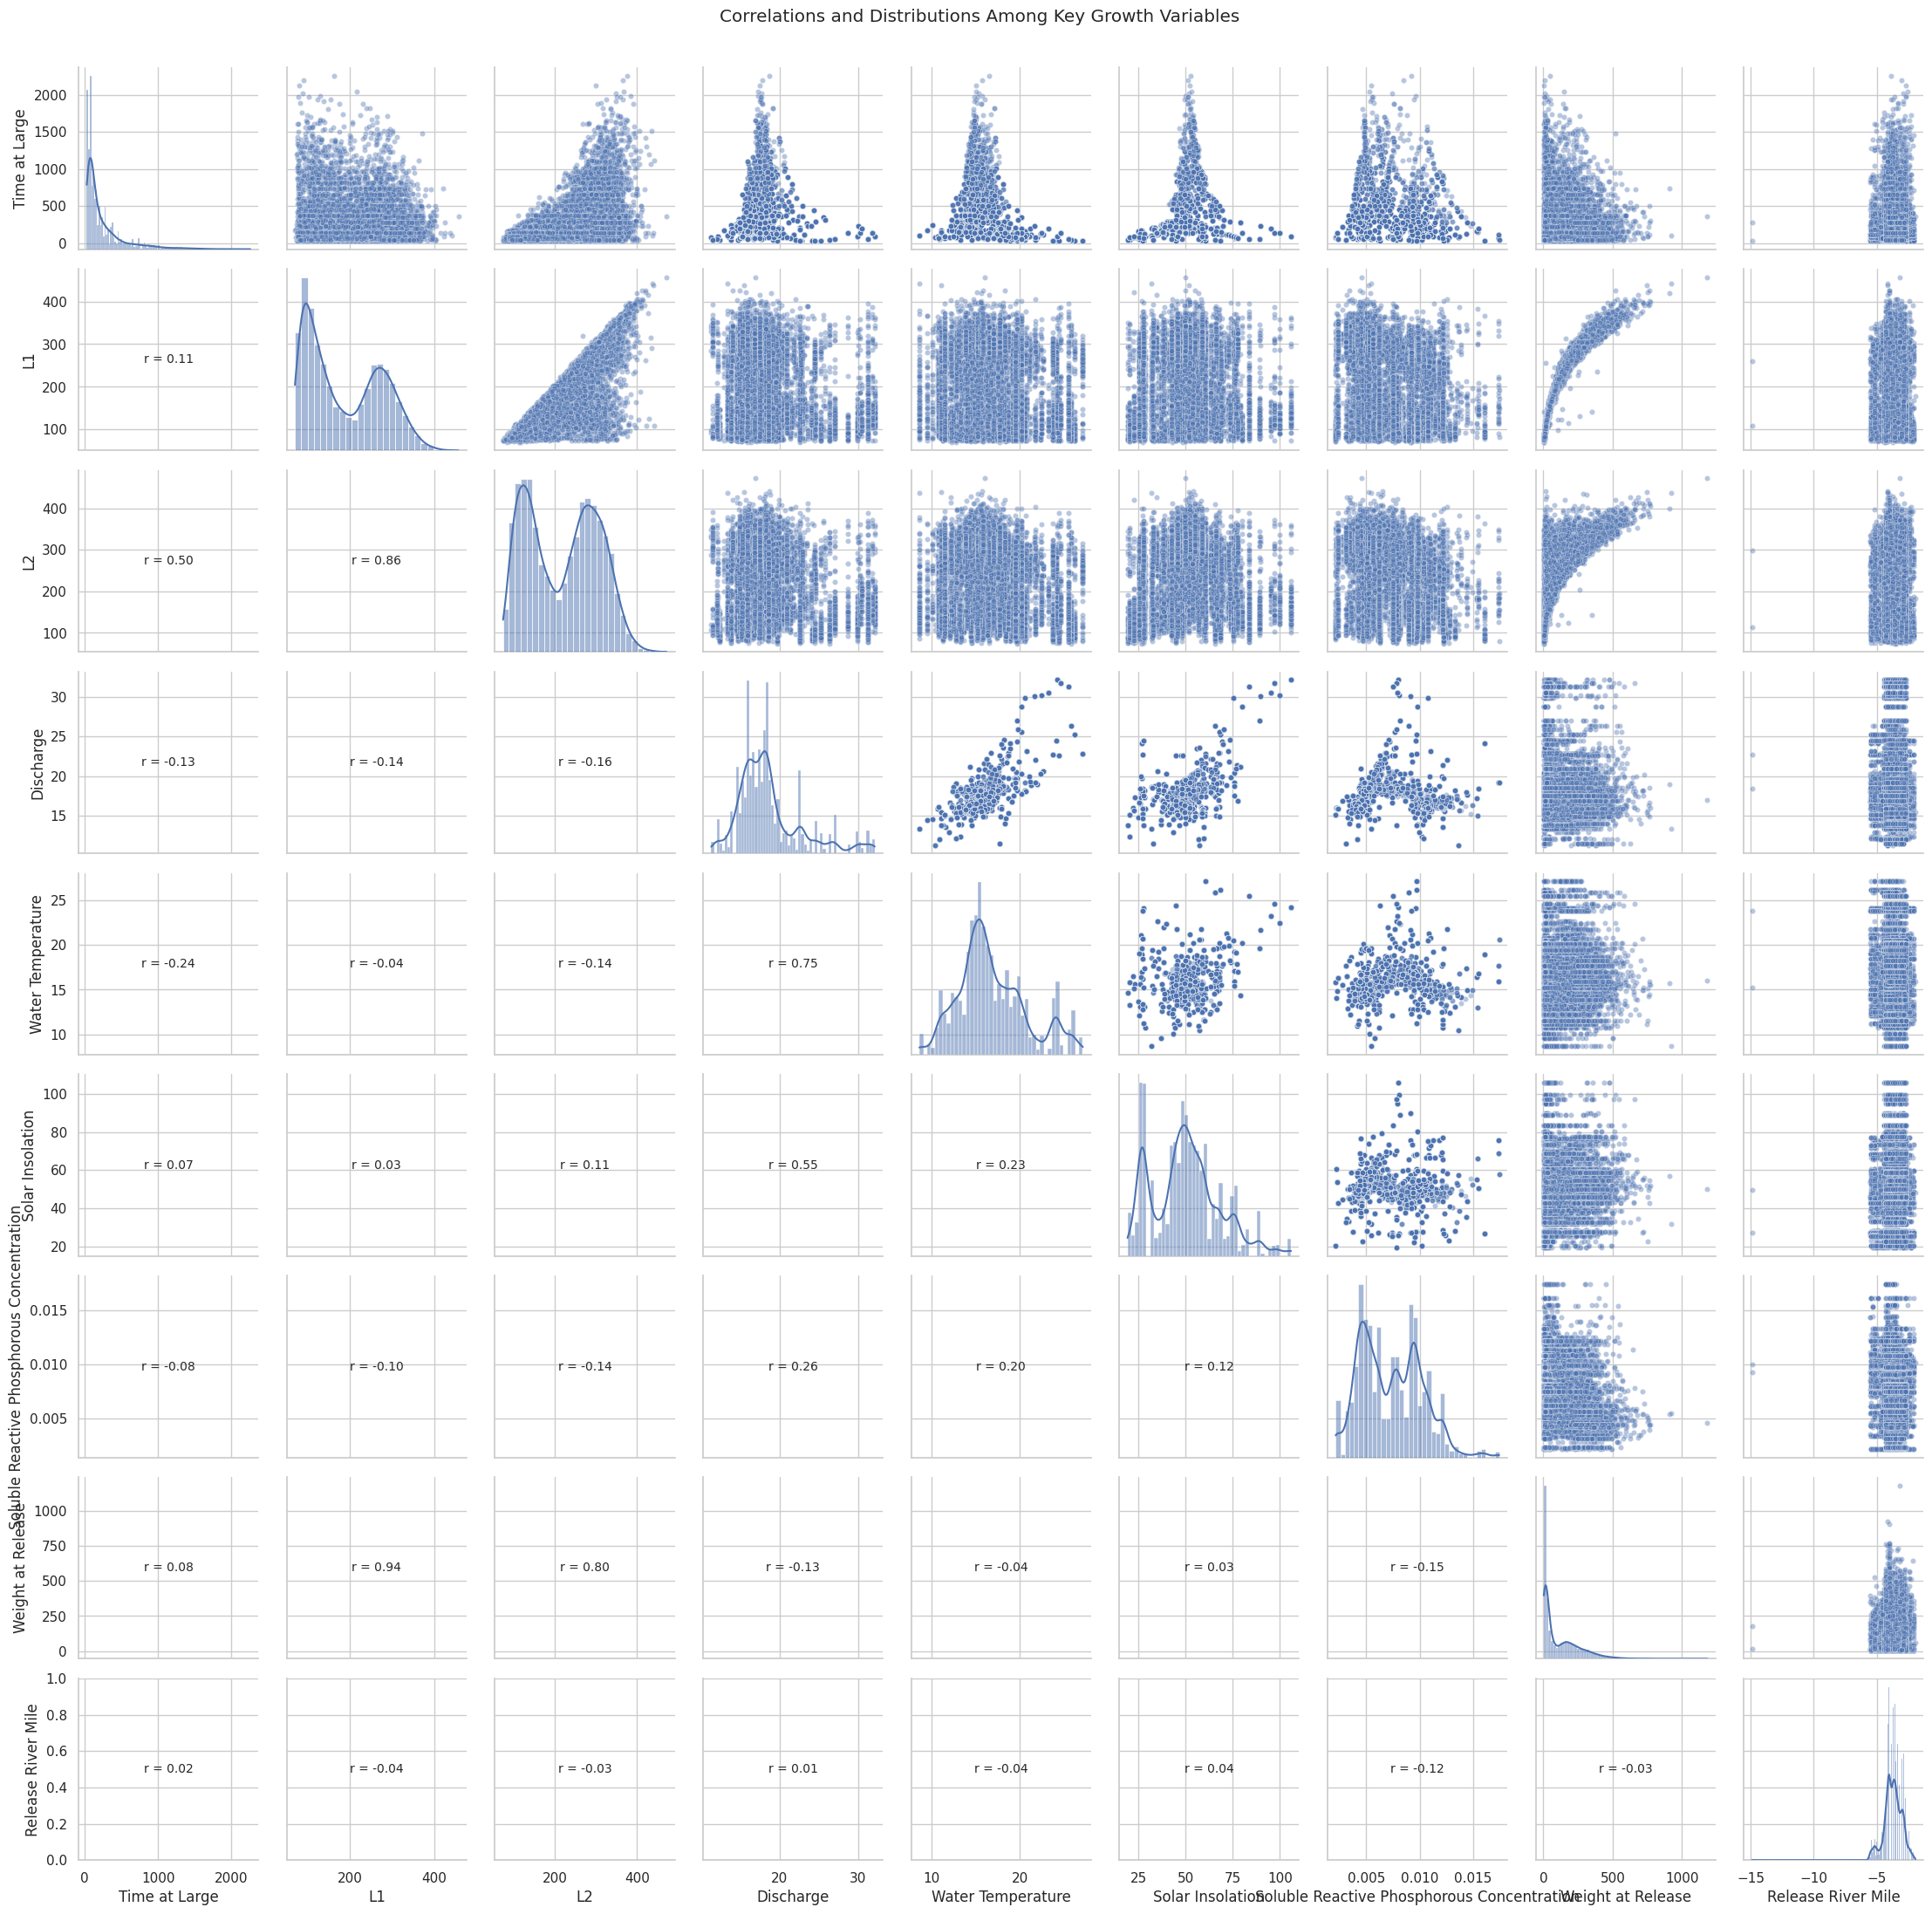

In [ ]:
from scipy.stats import pearsonr
from matplotlib.patches import Ellipse

# Subset of only continuous (non-dummy) variables
cont_vars = [
    'Time at Large', 'L1', 'L2',
    'Discharge', 'Water Temperature', 'Solar Insolation',
    'Soluble Reactive Phosphorous Concentration', 'Weight at Release',
    'Release River Mile'
]

df = fish_data[cont_vars].dropna()

# Custom PairGrid
g = sns.PairGrid(df, diag_sharey=False)

# Lower: correlation coefficients
def corr_func(x, y, **kwargs):
    r, _ = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(f'r = {r:.2f}', xy=(0.5, 0.5), xycoords=ax.transAxes,
                ha='center', va='center', fontsize=10)

# Upper: scatterplots (could sub with kde or box-like ellipses)
def scatter_func(x, y, **kwargs):
    ax = plt.gca()
    sns.scatterplot(x=x, y=y, alpha=0.4, s=20, ax=ax)

# Diagonal: histograms
g.map_lower(corr_func)
g.map_diag(sns.histplot, kde=True)
g.map_upper(scatter_func)

# Adjust layout
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Correlations and Distributions Among Key Growth Variables')
plt.show()


## Create Clean Dataset and Save

In [ ]:
# Export the processed data
fish_model_data = fish_data.copy()
fish_model_data.to_csv('fish_model_data.csv', index=False)
print("Data exported successfully to 'fish_model_data.csv'")

Data exported successfully to 'fish_model_data.csv'


# Metrics Function

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def get_model_metrics(y_true, y_pred, k_params=None, model_name="Model"):
    """
    Compute common regression metrics including AIC, AICC, BIC.

    Parameters:
    - y_true: array-like of true values
    - y_pred: array-like of predicted values
    - k_params: int, number of predictors (including intercept) [optional]
    - model_name: str, name to label the output

    Returns:
    - DataFrame row with metrics
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    n = len(y_true)
    k = k_params if k_params is not None else 1  # default to intercept-only

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Info criteria (use classical formulas here)
    aic = n * np.log(mse) + 2 * k
    aicc = aic + (2 * k * (k + 1)) / (n - k - 1) if (n - k - 1) > 0 else np.nan
    bic = n * np.log(mse) + k * np.log(n)

    metrics = {
        "RMSE": round(rmse, 3),
        "MAE": round(mae, 3),
        "R2": round(r2, 3),
        "AIC": round(aic, 3),
        "AICC": round(aicc, 3),
        "BIC": round(bic, 3)
    }

    return pd.DataFrame([metrics], index=[model_name])


# Train / Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X = fish_model_data.drop(columns=["L2"])
y = fish_model_data["L2"]  # Set dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Print dataset sizes

valid_indices=X_test.index
test_indices=X_test.index

y_test= fish_model_data.loc[valid_indices, "L2"]
y_true=y_test

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")



Training set size: 6858
Testing set size: 2940


# Bayesian OLS Model

## 📈 Bayesian OLS Regression Model

We estimate the posterior distribution of the regression coefficients $\boldsymbol{\beta}$ and observation noise $\sigma$ using Bayesian inference:

- $\mathbf{X}$: Design matrix (with intercept)  
- $\mathbf{y}$: Observed response  
- $\boldsymbol{\beta}$: Coefficients for each predictor  
- $\sigma$: Standard deviation of residuals

---

### 📌 Full Posterior

$$
\begin{aligned}
p(&\boldsymbol{\beta}, \sigma \mid \mathbf{X}, \mathbf{y}) = \\
&\frac{
    \underbrace{p(\mathbf{y} \mid \mathbf{X}, \boldsymbol{\beta}, \sigma)}_{\text{Likelihood}} \cdot
    \underbrace{p(\boldsymbol{\beta})}_{\text{Normal prior}} \cdot
    \underbrace{p(\log \sigma)}_{\text{LogNormal prior}}
}{
    \int \int p(\mathbf{y} \mid \mathbf{X}, \boldsymbol{\beta}, \sigma) \cdot p(\boldsymbol{\beta}) \cdot p(\log \sigma)\ d\boldsymbol{\beta}\ d\sigma
}
\end{aligned}
$$

---

### 🔢 Likelihood

$$
\mathbf{y} \sim \mathcal{N}(\mathbf{X} \boldsymbol{\beta},\ \sigma^2)
$$

---

### 🎲 Priors

- $\beta_j \sim \mathcal{N}(0,\ 5^2)$ for all $j$ (including intercept)  
- $\log \sigma \sim \mathcal{N}(0,\ 1^2)$  
- $\sigma = \exp(\log \sigma)$ (ensures positivity and improves sampling)

---

### 🧠 Notes

- Priors are weakly informative and symmetric around 0, allowing both positive and negative slopes.
- The log-normal prior on $\sigma$ stabilizes sampling while avoiding degenerate variance.
- The model is implemented in PyMC with vectorized operations for efficiency.


## OLS Estimation

In [ ]:
import pymc as pm
import arviz as az

# Convert data to numeric once and handle missing values properly
X_train_numeric = X_train.astype(float)
y_train_numeric = y_train.astype(float)

# Add constant efficiently using numpy instead of statsmodels
X_train_np = np.column_stack((np.ones(len(X_train_numeric)), X_train_numeric.values))
X_test_np = np.column_stack((np.ones(len(X_test)), X_test.astype(float).values))

# Get feature names for later reference
feature_names = ['intercept'] + X_train.columns.tolist()

# Use with to properly manage resources
with pm.Model() as bayesian_ols:
    # Use more efficient parameterization - sparse priors often sample better
    beta = pm.Normal("beta", mu=0, sigma=5, shape=X_train_np.shape[1])

    # Use log parameterization for sigma which often improves sampling
    log_sigma = pm.LogNormal("log_sigma", mu=0, sigma=1)
    sigma = pm.Deterministic("sigma", pm.math.exp(log_sigma))

    # Vectorized operations using tensor math
    mu = pm.math.dot(X_train_np, beta)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train_numeric.values)

    # Sample with optimized parameters
    trace = pm.sample(
        draws=2000,
        tune=1000,
        cores=1,  # Use multiple cores for parallel sampling
        chains=4,  # Multiple chains for better convergence assessment
        return_inferencedata=True,
        target_accept=0.95
    )

Output()

## OLS Energy Plot

<Axes: >

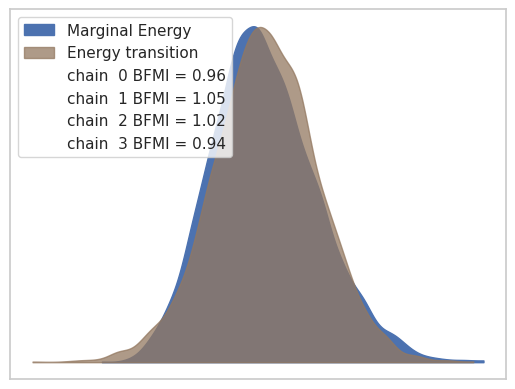

In [ ]:
az.plot_energy(trace)

## OLS Posterior Means

In [ ]:
# Extract posterior summaries in a more efficient way
def summarize_bayesian_model(trace, feature_names, hdi_prob=0.94):
    # Extract all summary statistics at once
    beta_means = trace.posterior['beta'].mean(dim=("chain", "draw")).values
    beta_medians = trace.posterior['beta'].median(dim=("chain", "draw")).values

    # Get HDI in one call
    hdi_beta = az.hdi(trace, var_names=['beta'], hdi_prob=hdi_prob)['beta']

    # Handle different HDI dimension naming conventions
    try:
        hdi_lower = hdi_beta.sel(hdi="lower").values
        hdi_upper = hdi_beta.sel(hdi="upper").values
    except KeyError:
        # Fall back to positional indexing if named dimensions aren't available
        hdi_lower = hdi_beta.isel(hdi=0).values
        hdi_upper = hdi_beta.isel(hdi=1).values

    # Create summary dataframe
    summary_df = pd.DataFrame({
        "Feature": feature_names,
        "Mean": beta_means,
        "Median": beta_medians,
        "HDI Lower": hdi_lower,
        "HDI Upper": hdi_upper
    })

    # Add column indicating if the credible interval excludes zero
    summary_df["Significant"] = ~((summary_df["HDI Lower"] <= 0) & (summary_df["HDI Upper"] >= 0))

    # Format and sort
    return summary_df.round(4).sort_values(by="Mean", key=abs, ascending=False).reset_index(drop=True)

# Use the function with your data
feature_names = ['intercept'] + X_train.columns.tolist()
summary_df = summarize_bayesian_model(trace, feature_names)

# Display the results
summary_df

,Feature,Mean,Median,HDI Lower,HDI Upper,Significant
0,intercept,30.5010,30.5268,25.6720,35.5915,True
1,RecoveryYear_2014,-10.9782,-10.9910,-13.4303,-8.6025,True
2,RecoveryYear_2012,-8.1539,-8.1507,-13.1944,-3.2106,True
3,RecoveryYear_2013,-6.2497,-6.2401,-9.0261,-3.4991,True
4,RecoveryMonth_4,-4.5957,-4.5838,-6.9915,-2.3297,True
5,RecoveryMonth_3,-3.5978,-3.6097,-7.0257,-0.4309,True
6,RecoveryYear_2021,2.7120,2.7217,0.0828,5.1647,True
7,Release River Mile,-2.3803,-2.3767,-3.1939,-1.5924,True
8,RecoveryYear_2019,2.1445,2.1221,-0.4520,4.5807,False
9,RecoveryYear_2015,-2.0218,-2.0236,-4.3744,0.1790,False


## OLS Posterior Diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],30.501,2.648,25.672,35.592,0.039,0.028,4701.0,4879.0,1.0
beta[1],-2.380,0.424,-3.194,-1.592,0.005,0.005,7515.0,5957.0,1.0
beta[2],0.118,0.001,0.116,0.120,0.000,0.000,7503.0,6199.0,1.0
beta[3],0.807,0.010,0.788,0.826,0.000,0.000,4595.0,4917.0,1.0
beta[4],-0.006,0.007,-0.019,0.007,0.000,0.000,4690.0,4676.0,1.0
beta[5],1.002,2.143,-3.058,4.988,0.027,0.022,6192.0,5978.0,1.0
beta[6],-3.598,1.754,-7.026,-0.431,0.024,0.019,5257.0,6116.0,1.0
beta[7],-4.596,1.242,-6.992,-2.330,0.019,0.013,4069.0,5414.0,1.0
beta[8],-0.652,1.236,-2.919,1.679,0.021,0.014,3352.0,5094.0,1.0
beta[9],0.377,4.644,-8.275,9.150,0.050,0.049,8673.0,5854.0,1.0


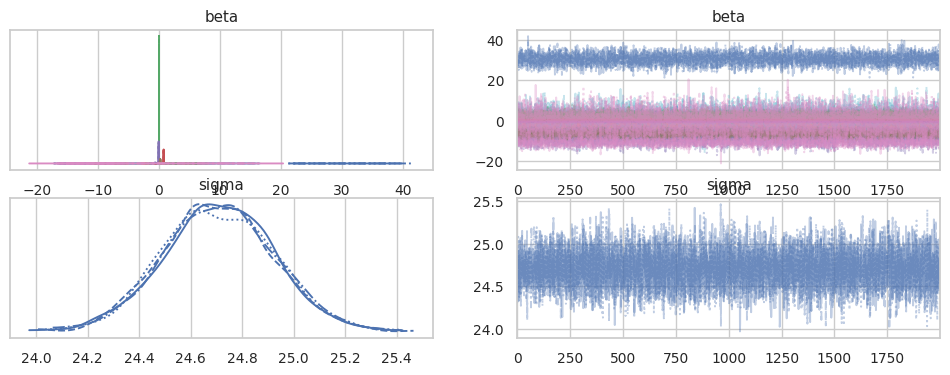

In [ ]:
# Trace plot for regression coefficients and observation noise
az.plot_trace(trace, var_names=["beta", "sigma"])

# Summary statistics
az.summary(trace, var_names=["beta", "sigma"]).round(3)


## Evaluation of $\hat{r}$, Gelman-Rubin Diagnostic

In [ ]:
az.rhat(trace).to_dataframe().describe()

,beta,log_sigma,sigma
count,27.000000,2.700000e+01,2.700000e+01
mean,1.000818,9.999892e-01,9.999892e-01
std,0.000379,2.262744e-16,2.262744e-16
min,1.000284,9.999892e-01,9.999892e-01
25%,1.000556,9.999892e-01,9.999892e-01
50%,1.000708,9.999892e-01,9.999892e-01
75%,1.000999,9.999892e-01,9.999892e-01
max,1.001635,9.999892e-01,9.999892e-01


## Evaluation of ESS

In [ ]:
az.ess(trace).to_dataframe().describe()

,beta,log_sigma,sigma
count,27.000000,2.700000e+01,2.700000e+01
mean,5068.368842,7.725822e+03,7.725822e+03
std,1435.131204,2.780460e-12,2.780460e-12
min,3352.354248,7.725822e+03,7.725822e+03
25%,4168.169436,7.725822e+03,7.725822e+03
50%,4595.294746,7.725822e+03,7.725822e+03
75%,5199.193353,7.725822e+03,7.725822e+03
max,8672.659852,7.725822e+03,7.725822e+03


## Predictions

In [ ]:
with bayesian_ols:
    posterior_pred = pm.sample_posterior_predictive(trace, var_names=["y_obs"], predictions=True)
# Extract posterior draws
posterior_betas = trace.posterior['beta'].stack(draws=("chain", "draw")).values
posterior_sigma = trace.posterior['sigma'].stack(draws=("chain", "draw")).values

# Generate predictions for each posterior sample
posterior_predictions = X_test_np @ posterior_betas  # Shape: [n_test, n_draws]

L2_pred_ols = posterior_predictions.mean(axis=1)

Output()

## Metrics

In [ ]:
highlight_df = pd.DataFrame(columns=['RMSE', 'MAE', 'R2', 'AIC', 'AICC', 'BIC'])
highlight_df = pd.concat([
    highlight_df,
    get_model_metrics(y_true, L2_pred_ols, k_params=X_test_np.shape[1], model_name="Bayesian OLS")
])
highlight_df

,RMSE,MAE,R2,AIC,AICC,BIC
Bayesian OLS,25.121,17.458,0.915,19009.349,19009.868,19170.975


# ML Model Libraries

In [ ]:
# Machine Learning and Model Training

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Advanced Machine Learning Frameworks
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor
import tensorflow as tf
import random


# Optimization
from scipy.optimize import minimize

# TensorFlow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

# Tree Models + Predictions + Metrics

In [ ]:
# Initialize a dictionary to store predictions
model_predictions = {}

# Define models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, bootstrap=True, max_depth=10, random_state=42),
    "XGBoost": xgb.XGBRegressor(colsample_bytree=0.7, subsample=0.9, max_depth=10, n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, colsample_bytree=0.9, max_depth=10, subsample=0.7, random_state=42, verbosity=-1)
}

# Evaluate each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Save prediction under standardized variable name
    var_name = f"L2_pred_{model_name.lower().replace(' ', '')}"  # e.g., L2_pred_randomforest
    model_predictions[var_name] = y_pred

    # Calculate number of parameters (features + intercept)
    k_params = X_test.shape[1] + 1

    # Compute and append metrics
    metrics_df = get_model_metrics(y_test, y_pred, k_params=k_params, model_name=model_name)
    highlight_df = pd.concat([highlight_df, metrics_df])

L2_pred_randomforest = model_predictions['L2_pred_randomforest']
L2_pred_xgboost = model_predictions['L2_pred_xgboost']
L2_pred_lightgbm = model_predictions['L2_pred_lightgbm']

highlight_df


,RMSE,MAE,R2,AIC,AICC,BIC
Bayesian OLS,25.121,17.458,0.915,19009.349,19009.868,19170.975
Random Forest,16.991,11.213,0.961,16710.172,16710.691,16871.799
XGBoost,18.028,12.049,0.956,17058.468,17058.988,17220.095
LightGBM,16.218,10.701,0.965,16436.460,16436.979,16598.086


# Neural Network

## NN Estimation

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 64)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,225 (16.50 KB)

 Trainable params: 4,033 (15.75 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.23277, saving model to best_model.keras
172/172 - 6s - 32ms/step - loss: 0.4620 - mae: 0.4672 - val_loss: 0.2328 - val_mae: 0.3126 - learning_rate: 1.0000e-03
Epoch 2/200

Epoch 2: val_loss improved from 0.23277 to 0.17182, saving model to best_model.keras
172/172 - 1s - 6ms/step - loss: 0.2697 - mae: 0.3621 - val_loss: 0.1718 - val_mae: 0.2638 - learning_rate: 1.0000e-03
Epoch 3/200

Epoch 3: val_loss improved from 0.17182 to 0.15346, saving model to best_model.keras
172/172 - 1s - 5ms/step - loss: 0.2225 - mae: 0.3252 - val_loss: 0.1535 - val_mae: 0.2531 - learning_rate: 1.0000e-03
Epoch 4/200

Epoch 4: val_loss improved from 0.15346 to 0.12828, saving model to best_model.keras
172/172 - 1s - 5ms/step - loss: 0.2013 - mae: 0.3100 - val_loss: 0.1283 - val_mae: 0.2221 - learning_rate: 1.0000e-03
Epoch 5/200

Epoch 5: val_loss improved from 0.12828 to 0.12395, saving model to best_model.keras
172/172 - 1s - 5ms/step - loss: 0.1890 - 

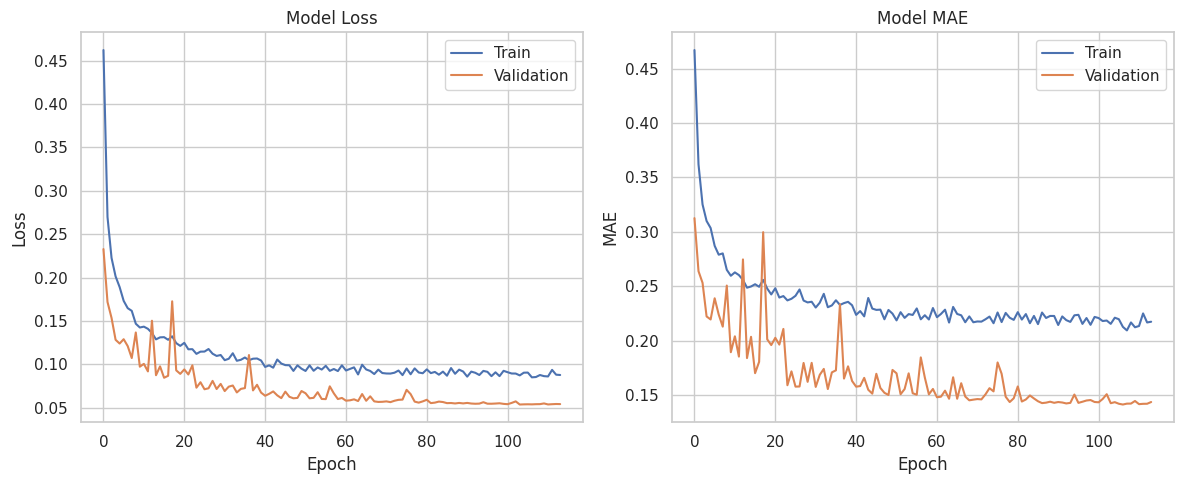

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Mean Squared Error (MSE): 302.9455
Test Mean Absolute Error (MAE): 11.9095


In [ ]:

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Save in Keras format
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


# Create the scaler
scaler = StandardScaler()


# Identify non-dummy (continuous) columns — you can do this manually or use dtype
non_dummy_cols = [
    'Time at Large',
    'Discharge', 'Water Temperature', 'Solar Insolation',
    'Soluble Reactive Phosphorous Concentration', 'L1']

# Scale only those columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[non_dummy_cols] = scaler.fit_transform(X_train[non_dummy_cols])
X_test_scaled[non_dummy_cols] = scaler.transform(X_test[non_dummy_cols])

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# Define the neural network architecture
model = Sequential()

# Input layer with batch normalization and leaky ReLU
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

# More efficient architecture - better for your data size
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

model.add(Dense(32, kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))  # Reduced dropout

model.add(Dense(1))

# Custom learning rate for optimizer
custom_optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=custom_optimizer, loss='mean_squared_error', metrics=['mae'])

# Print model summary
model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Train the model with callbacks
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=200,  # Increased max epochs (early stopping will prevent overfitting)
    batch_size=32,  # Smaller batch size for better generalization
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=2
)

# Visualize training history
plt.figure(figsize=(12, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation mean absolute error
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

y_pred_scaled = model.predict(X_test_scaled).ravel()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Compare to original (unscaled) test targets
test_loss = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print(f"Test Mean Squared Error (MSE): {test_loss:.4f}")
print(f"Test Mean Absolute Error (MAE): {test_mae:.4f}")

## NN Predictions

In [ ]:

# Load and predict
model = load_model('best_model.keras')
y_pred = model.predict(X_test_scaled).flatten()
L2_pred_nn = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


## NN Metrics

In [ ]:
# Determine k_params based on model attributes
if hasattr(model, 'count_params'):
    k_params = model.count_params()
elif hasattr(model, 'n_features_in_'):
    k_params = model.n_features_in_
else:
    k_params = 8  # fallback if necessary

# Generate metrics using the reusable function
nn_metrics = get_model_metrics(y_test, L2_pred_nn, k_params=k_params, model_name="NN")

# Append to comparison table
highlight_df = pd.concat([highlight_df, nn_metrics])

# Display result
highlight_df


,RMSE,MAE,R2,AIC,AICC,BIC
Bayesian OLS,25.121,17.458,0.915,19009.349,19009.868,19170.975
Random Forest,16.991,11.213,0.961,16710.172,16710.691,16871.799
XGBoost,18.028,12.049,0.956,17058.468,17058.988,17220.095
LightGBM,16.218,10.701,0.965,16436.460,16436.979,16598.086
NN,17.405,11.910,0.959,25247.846,NaN,50539.392


# SVR

## SVR Estimation

In [ ]:
from sklearn.svm import SVR

# === Initialize and Fit SVR ===
svr_model = SVR(kernel='rbf',C=1, gamma=.1, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train_scaled)


SVR(C=1, gamma=0.1)

## SVR Predictions

In [ ]:
# === Predict ===
y_pred = svr_model.predict(X_test_scaled)
L2_pred_svr = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()


## SVR Metrics

In [ ]:
# Estimate SVR model complexity
k_params = 3  # Set based on domain knowledge or support vectors approximation

# Get performance metrics using the function
svr_metrics = get_model_metrics(y_test, L2_pred_svr, k_params=k_params, model_name="SVR")

# Append to the comparison table
highlight_df = pd.concat([highlight_df, svr_metrics])

# View the updated comparison
highlight_df


,RMSE,MAE,R2,AIC,AICC,BIC
Bayesian OLS,25.121,17.458,0.915,19009.349,19009.868,19170.975
Random Forest,16.991,11.213,0.961,16710.172,16710.691,16871.799
XGBoost,18.028,12.049,0.956,17058.468,17058.988,17220.095
LightGBM,16.218,10.701,0.965,16436.460,16436.979,16598.086
NN,17.405,11.910,0.959,25247.846,NaN,50539.392
SVR,22.600,15.389,0.931,18339.502,18339.510,18357.461


# KNN

## KNN Estimation

In [ ]:
# === Use Optimal K from Cross-Validation ===
knn_model = KNeighborsRegressor(n_neighbors=4)
knn_model.fit(X_train_scaled, y_train_scaled)


KNeighborsRegressor(n_neighbors=4)

## KNN Predictions

In [ ]:
# === Predict on Test Data ===
y_pred = knn_model.predict(X_test_scaled)
L2_pred_knn = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()

## KNN Metrics

In [ ]:
# === Evaluate and Append with Universal Function ===
k_params = 3  # Proxy for model complexity (can adjust if needed)
knn_metrics = get_model_metrics(y_test, L2_pred_knn, k_params=k_params, model_name="KNN")

# Append to your master metrics DataFrame
highlight_df = pd.concat([highlight_df, knn_metrics])
highlight_df


,RMSE,MAE,R2,AIC,AICC,BIC
Bayesian OLS,25.121,17.458,0.915,19009.349,19009.868,19170.975
Random Forest,16.991,11.213,0.961,16710.172,16710.691,16871.799
XGBoost,18.028,12.049,0.956,17058.468,17058.988,17220.095
LightGBM,16.218,10.701,0.965,16436.460,16436.979,16598.086
NN,17.405,11.910,0.959,25247.846,NaN,50539.392
SVR,22.600,15.389,0.931,18339.502,18339.510,18357.461
KNN,23.186,15.963,0.928,18490.175,18490.183,18508.133


# Biological Models

We model L2 for consistency across models.

## 🐟 Bayesian Fabens Growth Model

We estimate the posterior distribution of the parameters $L_\infty$, $k$, and $\sigma$ using Bayesian inference, given tag-recapture data:

- $L_1$: Length at release  
- $L_2$: Length at recapture  
- $\Delta t$: Time at large (in years)

---

### 📌 Full Posterior

$$
\begin{aligned}
p(&L_\infty, k, \sigma_{\text{obs}}, \sigma_{L_\infty} \mid L_1, \Delta t, L_2) = \\
&\frac{
    \underbrace{p(L_2 \mid L_1, \Delta t, L_\infty, k, \sigma_{\text{obs}})}_{\text{Likelihood}} \cdot
    \underbrace{p(L_\infty \mid \sigma_{L_\infty})}_{\text{Hierarchical Normal prior}} \cdot
    \underbrace{p(k)}_{\text{HalfNormal prior}} \cdot
    \underbrace{p(\sigma_{\text{obs}})}_{\text{HalfNormal}} \cdot
    \underbrace{p(\sigma_{L_\infty})}_{\text{HalfNormal}}
}{
    \int \cdots \int \text{same terms}\ dL_\infty\, dk\, d\sigma_{\text{obs}}\, d\sigma_{L_\infty}
}
\end{aligned}
$$

---

### 🔢 Likelihood

$$
L_2 \sim \mathcal{N} \left( L_\infty - (L_\infty - L_1) e^{-k \Delta t},\ \sigma_{\text{obs}}^2 \right)
$$

---

### 🎲 Priors

- $\sigma_{\text{obs}} \sim \mathrm{HalfNormal}(2)$  
- $\sigma_{L_\infty} \sim \mathrm{HalfNormal}(2)$  
- $L_\infty \sim \mathcal{N}(500,\ \sigma_{L_\infty}^2)$  
- $k \sim \mathrm{HalfNormal}(1)$





## VBGM Estimation



In [ ]:
import pymc as pm
import arviz as az
import numpy as np

# Biological predictors (unscaled)
dt = X_train["Time at Large"].values.astype(np.float64)
L1 = X_train["L1"].values.astype(np.float64)
L2 = y_train.values.astype(np.float64)

# Scaled continuous covariates
X_env_scaled = X_train_scaled[
    [
        "Release River Mile",
        "Weight at Release",
        "Discharge",
        "Water Temperature",
        "Solar Insolation",
        "Soluble Reactive Phosphorous Concentration"
    ]
].values.astype(np.float64)

# Dummies to include (already in 0/1 form)
X_dummies = X_train[
    [col for col in X_train.columns if "RecoveryMonth_" in col or "RecoveryYear_" in col]
].values.astype(np.float64)

# Combine scaled continuous + dummy predictors
X_combined = np.hstack([X_env_scaled, X_dummies])

with pm.Model() as vbgm_model:

    # Data containers
    dt_data = pm.MutableData("dt", dt)
    L1_data = pm.MutableData("L1", L1)
    X_data = pm.MutableData("X_combined", X_combined)

    # Priors
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=2)
    sigma_Linf = pm.HalfNormal("sigma_Linf", sigma=2)
    L_inf = pm.Normal("L_inf", mu=500, sigma=sigma_Linf)

    # k as function of scaled covariates + regularized dummies
    alpha_k = pm.Normal("alpha_k", mu=0, sigma=1)
    beta_k = pm.Normal("beta_k", mu=0, sigma=1, shape=X_env_scaled.shape[1])
    beta_dummies = pm.Normal("beta_dummies", mu=0, sigma=0.2, shape=X_dummies.shape[1])  # tighter prior

    # Combine effects into one linear term
    linear_k = alpha_k + pm.math.dot(X_data[:, :X_env_scaled.shape[1]], beta_k) + pm.math.dot(X_data[:, X_env_scaled.shape[1]:], beta_dummies)
    k = pm.Deterministic("k", pm.math.exp(linear_k))  # Enforce positivity

    # VBGM prediction
    L2_hat = L_inf - (L_inf - L1_data) * pm.math.exp(-k * dt_data)

    # Likelihood
    obs = pm.Normal("obs", mu=L2_hat, sigma=sigma_obs, observed=L2)

    # Sampling
    trace_vbgm = pm.sample(
        draws=2000,
        tune=1000,
        target_accept=0.95,  # More careful steps with dummies
        chains=4,
        cores=1,  # For Colab
        return_inferencedata=True
    )


Output()

## VBGM Posterior Diagnostics

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L_inf,419.376,5.278,410.051,429.603,0.102,0.082,2694.0,2506.0,1.0
sigma_obs,17.892,0.149,17.617,18.172,0.002,0.002,5087.0,3126.0,1.0


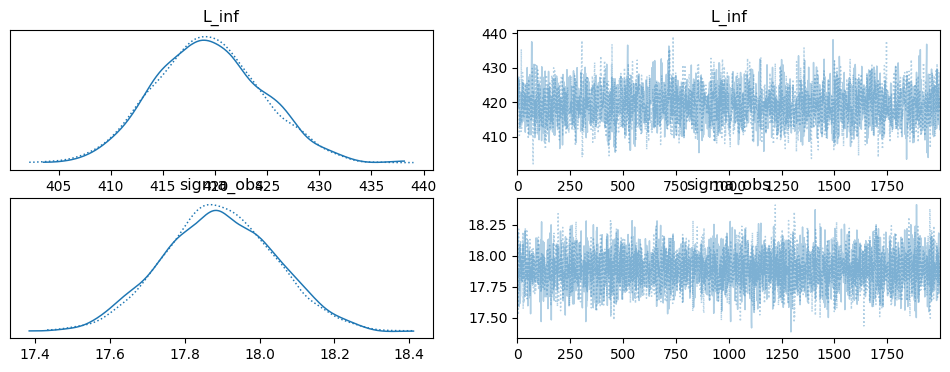

In [ ]:
az.plot_trace(trace_vbgm, var_names=["L_inf", "sigma_obs"])
az.summary(trace_vbgm, var_names=["L_inf", "sigma_obs"]).round(3)

## VBGM Energy Plot

<Axes: >

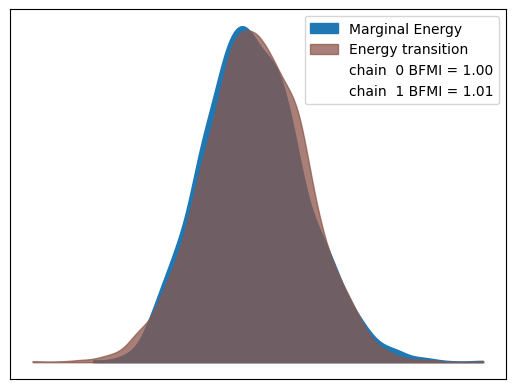

In [ ]:
az.plot_energy(trace)

## VBGM Prediction

In [ ]:


# Extract test values
dt_test = X_test["Time at Large"].values.astype(np.float64)
L1_test = X_test["L1"].values.astype(np.float64)
L2_actual = y_test.values.astype(np.float64)

# Get posterior means of alpha_k and beta_k
alpha_k_post = trace_vbgm.posterior["alpha_k"].mean().item()
beta_k_post = trace_vbgm.posterior["beta_k"].mean(dim=("chain", "draw")).values

# Get the same scaled environmental variables for test set
X_env_test_scaled = X_test_scaled[
    [
        "Release River Mile",
        "Weight at Release",
        "Discharge",
        "Water Temperature",
        "Solar Insolation",
        "Soluble Reactive Phosphorous Concentration"
    ]
].values.astype(np.float64)

# Reconstruct k for each test row
k_test = np.exp(alpha_k_post + np.dot(X_env_test_scaled, beta_k_post))

# Posterior mean of L_inf (scalar)
L_inf_post = trace_vbgm.posterior["L_inf"].mean().item()

# Final predictions using vectorized k
L2_pred_vbgm = L_inf_post - (L_inf_post - L1_test) * np.exp(-k_test * dt_test)


## VBGMF Metrics

In [ ]:
# Use your unified metrics function
vbgm_metrics = get_model_metrics(
    y_true=L2_actual,
    y_pred=L2_pred_vbgm,
    k_params=3,  # L_inf, k, sigma_obs
    model_name="Traditional VBGM"
)

highlight_df = pd.concat([highlight_df, vbgm_metrics])
highlight_df



,RMSE,MAE,R2,AIC,AICC,BIC
Bayesian OLS,24.395,16.757,0.920,18872.854,18874.285,19142.232
Random Forest,16.974,11.184,0.961,16740.346,16741.776,17009.723
XGBoost,17.763,11.775,0.958,17007.509,17008.939,17276.886
LightGBM,16.125,10.660,0.965,16438.559,16439.990,16707.937
NN,17.272,11.908,0.960,125810.777,NaN,452230.361
SVR,22.865,15.601,0.930,18408.021,18408.029,18425.979
KNN,19855.196,18581.942,-52962.638,58195.780,58195.788,58213.738
Traditional VBGM,18.730,12.928,0.953,17235.059,17235.068,17253.018


# Bayesian Gompertz Model

## 🐟 Bayesian Gompertz Growth Model

We estimate the posterior distribution of the parameters $L_\infty$, $k$, and $\sigma$ using Bayesian inference, given tag-recapture data:

- $L_1$: Length at release  
- $L_2$: Length at recapture  
- $\Delta t$: Time at large (in years)

---

### 📌 Full Posterior

$$
\begin{aligned}
p(&L_\infty, k, \sigma_{\text{obs}}, \sigma_{L_\infty} \mid L_1, \Delta t, L_2) = \\
&\frac{
  \underbrace{p(L_2 \mid L_1, \Delta t, L_\infty, k, \sigma_{\text{obs}})}_{\text{Likelihood}} \cdot
  \underbrace{p(L_\infty \mid \sigma_{L_\infty})}_{\text{Hierarchical prior}} \cdot
  \underbrace{p(k)}_{\text{Prior}} \cdot
  \underbrace{p(\sigma_{\text{obs}})}_{\text{Prior}} \cdot
  \underbrace{p(\sigma_{L_\infty})}_{\text{Prior}}
}{
  \int \cdots \int \text{same terms} \ dL_\infty\, dk\, d\sigma_{\text{obs}}\, d\sigma_{L_\infty}
}
\end{aligned}
$$

---

### 🔢 Likelihood

$$
L_2 \sim \mathcal{N} \left( L_\infty \cdot \exp\left[ \ln\left(\frac{L_1}{L_\infty} \right) \cdot e^{-k \Delta t} \right],\ \sigma_{\text{obs}}^2 \right)
$$

---

### 🎲 Priors

- $ \sigma_{\text{obs}} \sim \text{HalfNormal}(2) $  
- $ \sigma_{L_\infty} \sim \text{HalfNormal}(2) $  
- $ L_\infty \sim \mathcal{N}(500,\ \sigma_{L_\infty}^2) $  
- $ k \sim \text{HalfNormal}(1) $

---


## GM Estimation

In [ ]:
import pymc as pm
import arviz as az

# Biological predictors (unscaled)
dt = X_train["Time at Large"].values / 365.0  # Convert days to years
L1 = X_train["L1"].values.astype(np.float64)
L2 = y_train.values.astype(np.float64)

# Scaled continuous covariates
X_env_scaled = X_train_scaled[
    [
        "Release River Mile",
        "Weight at Release",
        "Discharge",
        "Water Temperature",
        "Solar Insolation",
        "Soluble Reactive Phosphorous Concentration"
    ]
].values.astype(np.float64)

# Dummy variables (ReleaseMonth_, RecoveryMonth_, RecoveryYear_)
X_dummies = X_train[
    [col for col in X_train.columns if "ReleaseMonth_" in col or "RecoveryMonth_" in col or "RecoveryYear_" in col]
].values.astype(np.float64)

# Combined design matrix: environmental covariates + dummies
X_combined = np.hstack([X_env_scaled, X_dummies])

with pm.Model() as gompertz_model:

    # Data containers
    dt_data = pm.MutableData("dt", dt)
    L1_data = pm.MutableData("L1", L1)
    X_data = pm.MutableData("X_combined", X_combined)

    # Priors
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=2)
    sigma_Linf = pm.HalfNormal("sigma_Linf", sigma=2)
    L_inf = pm.Normal("L_inf", mu=500, sigma=sigma_Linf)

    # Gompertz growth rate k ~ f(covariates + dummies)
    alpha_k = pm.Normal("alpha_k", mu=0, sigma=1)
    beta_k = pm.Normal("beta_k", mu=0, sigma=0.5, shape=X_env_scaled.shape[1])  # tighter prior
    beta_dummies = pm.Normal("beta_dummies", mu=0, sigma=0.2, shape=X_dummies.shape[1])  # regularized dummies

    # Linear predictor for k
    linear_k = (
        alpha_k
        + pm.math.dot(X_data[:, :X_env_scaled.shape[1]], beta_k)
        + pm.math.dot(X_data[:, X_env_scaled.shape[1]:], beta_dummies)
    )
    k = pm.Deterministic("k", pm.math.exp(linear_k))  # Ensure positivity

    # Gompertz prediction
    log_ratio = pm.math.log(L1_data / L_inf)
    L2_hat = L_inf * pm.math.exp(log_ratio * pm.math.exp(-k * dt_data))

    # Likelihood
    obs = pm.Normal("obs", mu=L2_hat, sigma=sigma_obs, observed=L2)

    # Sampling
    trace_gomp = pm.sample(
        draws=2000,
        tune=1000,
        target_accept=0.95,
        chains=4,
        cores=1,  # Colab-safe
        return_inferencedata=True
    )


Output()

## GM Posterior Diagnostics

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L_inf,364.227,2.199,360.08,368.420,0.038,0.032,3374.0,3121.0,1.0
sigma_obs,17.964,0.156,17.67,18.251,0.002,0.003,3952.0,2605.0,1.0


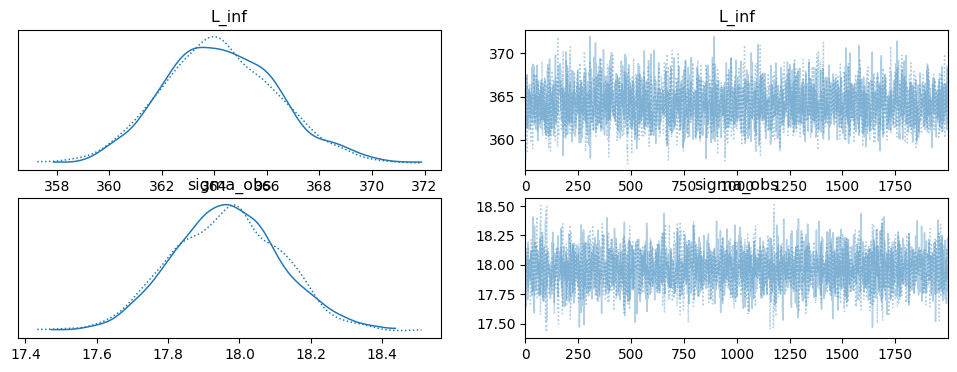

In [ ]:
az.plot_trace(trace_gomp, var_names=["L_inf", "sigma_obs"])
az.summary(trace_gomp, var_names=["L_inf", "sigma_obs"]).round(3)

## GM Energy Plot

<Axes: >

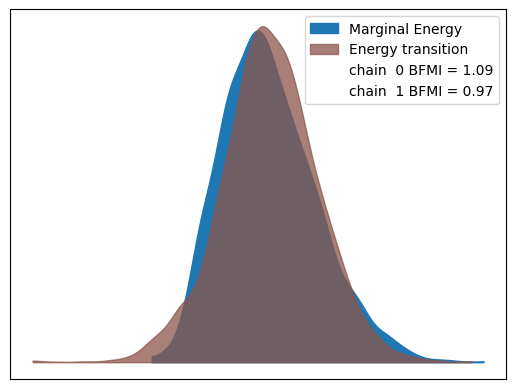

In [ ]:
az.plot_energy(trace_gomp)

## GM Prediction

In [ ]:
import numpy as np

# Test data (unscaled for L1 and dt)
dt_test = X_test["Time at Large"].values / 365.0  # Convert days to years
L1_test = X_test["L1"].values.astype(np.float64)
L2_actual = y_test.values.astype(np.float64)

# Scaled environmental predictors for test set
X_env_test_scaled = X_test_scaled[
    [
        "Release River Mile",
        "Weight at Release",
        "Discharge",
        "Water Temperature",
        "Solar Insolation",
        "Soluble Reactive Phosphorous Concentration"
    ]
].values.astype(np.float64)

# Posterior means
alpha_k_post = trace_gomp.posterior["alpha_k"].mean().item()
beta_k_post = trace_gomp.posterior["beta_k"].mean(dim=("chain", "draw")).values
L_inf_post = trace_gomp.posterior["L_inf"].mean().item()

# Recompute k for each test observation
k_test = np.exp(alpha_k_post + np.dot(X_env_test_scaled, beta_k_post))

# Gompertz prediction
log_ratio = np.log(L1_test / L_inf_post)
L2_pred_gompertz = L_inf_post * np.exp(log_ratio * np.exp(-k_test * dt_test))


## GM Metrics

In [ ]:
# Use your standardized metrics function
gompertz_metrics = get_model_metrics(
    y_true=L2_actual,
    y_pred=L2_pred_gompertz,
    k_params=4,  # L_inf, k, t0, sigma_obs
    model_name="Traditional Gompertz"
)

highlight_df = pd.concat([highlight_df, gompertz_metrics])
highlight_df


,RMSE,MAE,R2,AIC,AICC,BIC
Bayesian OLS,24.395,16.757,0.920,18872.854,18874.285,19142.232
Random Forest,16.974,11.184,0.961,16740.346,16741.776,17009.723
XGBoost,17.763,11.775,0.958,17007.509,17008.939,17276.886
LightGBM,16.125,10.660,0.965,16438.559,16439.990,16707.937
NN,17.272,11.908,0.960,125810.777,NaN,452230.361
SVR,22.865,15.601,0.930,18408.021,18408.029,18425.979
KNN,19855.196,18581.942,-52962.638,58195.780,58195.788,58213.738
Traditional VBGM,18.730,12.928,0.953,17235.059,17235.068,17253.018
Traditional Gompertz,18.796,12.972,0.953,17257.970,17257.984,17281.915


# Curves

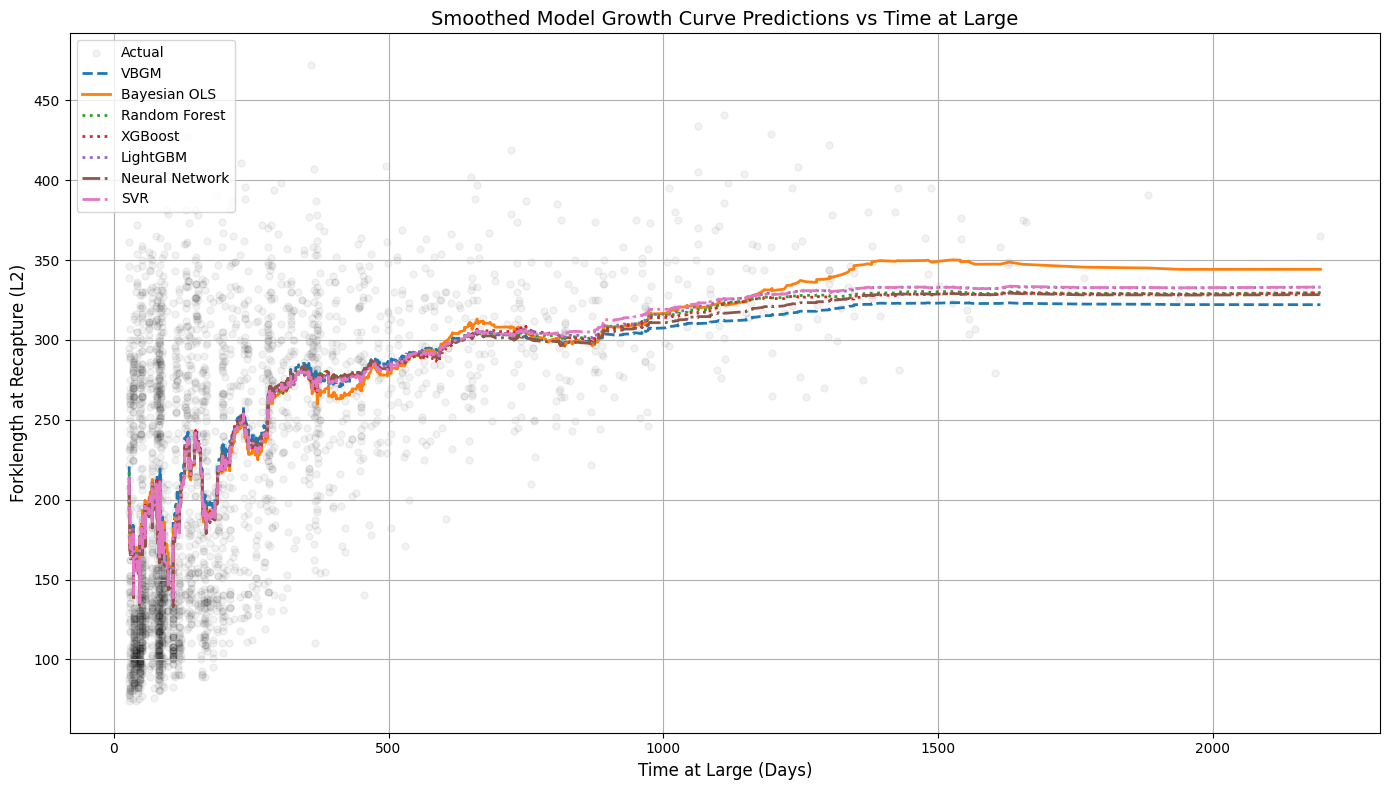

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
import numpy as np

# === Step 1: Sort Time at Large and apply to all variables ===
sorted_indices = np.argsort(dt_test)
dt_sorted = dt_test[sorted_indices]
L2_actual_sorted = L2_actual[sorted_indices]

# === Apply sorting to predictions ===
L2_pred_vbgm_sorted = L2_pred_vbgm[sorted_indices]
L2_pred_gompertz_sorted = L2_pred_gompertz[sorted_indices]
L2_pred_bayesols_sorted = L2_pred_ols[sorted_indices]
L2_pred_randomforest_sorted = L2_pred_randomforest[sorted_indices]
L2_pred_xgboost_sorted = L2_pred_xgboost[sorted_indices]
L2_pred_lightgbm_sorted = L2_pred_lightgbm[sorted_indices]
L2_pred_nn_sorted = L2_pred_nn[sorted_indices]
L2_pred_svr_sorted = L2_pred_svr[sorted_indices]



# === Smoothing for tree-based and SVR models ===
L2_pred_randomforest_smooth = uniform_filter1d(L2_pred_randomforest_sorted, size=100)
L2_pred_xgboost_smooth = uniform_filter1d(L2_pred_xgboost_sorted, size=100)
L2_pred_lightgbm_smooth = uniform_filter1d(L2_pred_lightgbm_sorted, size=100)
L2_pred_svr_smooth = uniform_filter1d(L2_pred_svr_sorted, size=100)


# Adjust smoothing kernel size for noisy models
L2_pred_bayesols_smooth = uniform_filter1d(L2_pred_bayesols_sorted, size=100)
L2_pred_nn_smooth = uniform_filter1d(L2_pred_nn_sorted, size=100)
L2_pred_vgbm_smooth = uniform_filter1d(L2_pred_vbgm_sorted, size=100)

# === Step 2: Plot ===
plt.figure(figsize=(14, 8))

# Actual data points
plt.scatter(dt_sorted, L2_actual_sorted, color='black', alpha=0.05, label="Actual", s=25)

# Model growth curves
plt.plot(dt_sorted, L2_pred_vgbm_smooth, label="VBGM", linestyle="--", linewidth=2)
#plt.plot(dt_sorted, L2_pred_gompertz_sorted, label="Gompertz", linestyle="--", linewidth=2)
plt.plot(dt_sorted, L2_pred_bayesols_smooth, label="Bayesian OLS", linestyle="-", linewidth=2)
plt.plot(dt_sorted, L2_pred_randomforest_smooth, label="Random Forest", linestyle=":", linewidth=2)
plt.plot(dt_sorted, L2_pred_xgboost_smooth, label="XGBoost", linestyle=":", linewidth=2)
plt.plot(dt_sorted, L2_pred_lightgbm_smooth, label="LightGBM", linestyle=":", linewidth=2)
plt.plot(dt_sorted, L2_pred_nn_smooth, label="Neural Network", linestyle="-.", linewidth=2)
plt.plot(dt_sorted, L2_pred_svr_smooth, label="SVR", linestyle="dashdot", linewidth=2)

# Plot decorations
plt.title("Smoothed Model Growth Curve Predictions vs Time at Large", fontsize=14)
plt.xlabel("Time at Large (Days)", fontsize=12)
plt.ylabel("Forklength at Recapture (L2)", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature Importance / Standardized Coefficients /



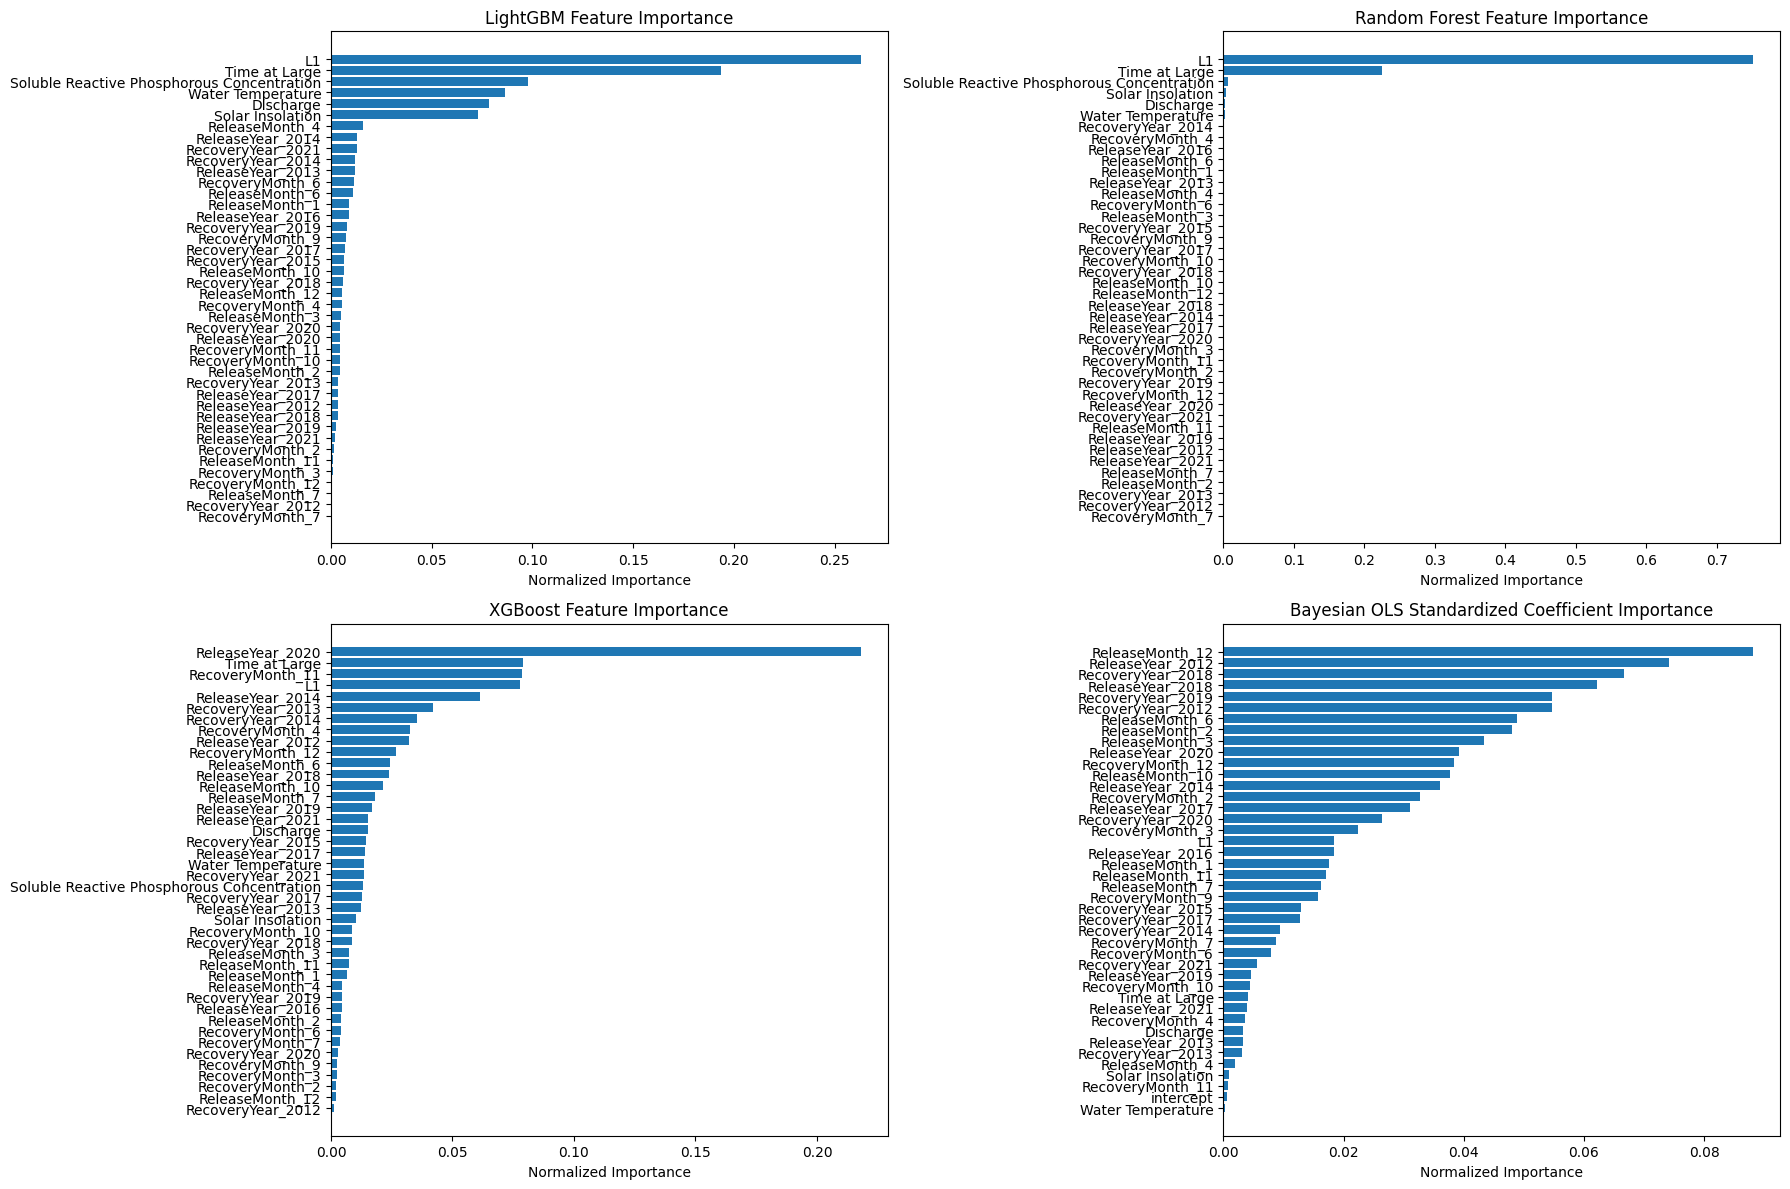

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Standardize X and y for OLS
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_std = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns)
y_train_std = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()


# Pull posterior mean of coefficients from Bayesian trace
bayes_ols_means = trace.posterior["beta"].mean(dim=["chain", "draw"]).values

# Optional: take absolute value for interpretability
ols_std_coefs = np.abs(bayes_ols_means[1:])  # exclude intercept
ols_features = feature_names  # already matches beta ordering (after intercept)

# Get feature names
feature_names = X_train.columns.tolist()

# Collect feature importances
lgb_importances = models["LightGBM"].feature_importances_
rf_importances = models["Random Forest"].feature_importances_
xgb_importances = models["XGBoost"].feature_importances_

# Normalize for comparison
def normalize(v):
    return v / np.sum(v)

lgb_norm = normalize(lgb_importances)
rf_norm = normalize(rf_importances)
xgb_norm = normalize(xgb_importances)
ols_norm = normalize(ols_std_coefs)

# Set up 2x2 plot grid
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
axs = axs.flatten()

def plot_importance(ax, importances, features, title):
    sorted_idx = np.argsort(importances)
    ax.barh(np.array(features)[sorted_idx], importances[sorted_idx])
    ax.set_title(title)
    ax.set_xlabel("Normalized Importance")

# Plot each model
plot_importance(axs[0], lgb_norm, feature_names, "LightGBM Feature Importance")
plot_importance(axs[1], rf_norm, feature_names, "Random Forest Feature Importance")
plot_importance(axs[2], xgb_norm, feature_names, "XGBoost Feature Importance")
plot_importance(axs[3], ols_norm, ols_features, "Bayesian OLS Standardized Coefficient Importance")

plt.tight_layout()
plt.show()


# Hyperparameter Runs (Converted to Markdown)

from sklearn.model_selection import GridSearchCV


## Hyperparameter Tuning, RF
rf = RandomForestRegressor(random_state=42)

## Define the parameter distribution
param_grid = {
    'n_estimators': [100, 150, 200],       # Number of trees
    'max_depth': [5, 10, 15],          # Depth of trees
    'bootstrap': [True, False]             # Bootstrapping options
}

## Initialize model
rf = RandomForestRegressor(random_state=42)

## Define grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=2,
    verbose=2,
    n_jobs=-1
)

## Fit grid search
grid_search.fit(X_train, y_train)

## Get best model
best_rf_model = grid_search.best_estimator_
print("Best Parameters:\n", grid_search.best_params_)


## Hyperparameter Tuning, LGBM

param_grid_lgbm = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

# Initialize model
lgbm = LGBMRegressor(random_state=42)

# Set up grid search
grid_search_lgbm = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid_lgbm,
    scoring='neg_mean_squared_error',
    cv=2,
    verbose=2,
    n_jobs=-1
)

# Fit the grid search
grid_search_lgbm.fit(X_train, y_train)

## Get best model
best_lgbm_model = grid_search_lgbm.best_estimator_
print("Best Parameters:\n", grid_search_lgbm.best_params_)



## Hyperparameter Tuning, XGBoost
param_grid_xgb = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Initialize model
xgb_model = XGBRegressor(random_state=42, verbosity=0)

# Grid search
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=2,
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search_xgb.fit(X_train, y_train)

## Get best model
best_lgbm_model = grid_search_xgb.best_estimator_
print("Best Parameters:\n", grid_search_xgb.best_params_)



## Hyperparameter Tuning, KNN

from sklearn.model_selection import GridSearchCV

# Define the model and parameter grid
knn = KNeighborsRegressor()
param_grid = {'n_neighbors': list(range(1, 31))}

# Set up grid search with 5-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit on training data
grid_search.fit(X_train_scaled, y_train_scaled)

# Best K
best_k = grid_search.best_params_['n_neighbors']
print(f"Optimal K: {best_k}")

# Best model
best_knn_model = grid_search.best_estimator_


## Hyperparameter Tuning, SVR

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

## Hyperparameter Tuning, SVR
svr = SVR()

# Simplified parameter grid for faster initial tuning
param_grid = [
    {
        'kernel': ['linear'],
        'C': [1, 10],
        'epsilon': [0.01, 0.1, 0.5]
    },
    {
        'kernel': ['rbf'],
        'C': [1, 10],
        'gamma': ['scale', 0.1],
        'epsilon': [0.01, 0.1, 0.5]
    },
    {
        'kernel': ['poly'],
        'C': [1],
        'degree': [2, 3],
        'gamma': ['scale'],
        'coef0': [0],
        'epsilon': [0.01, 0.1, 0.5]
    }
]

# Set up grid search with 2-fold cross-validation for faster runtime
grid_search = GridSearchCV(
    svr,
    param_grid,
    cv=2,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train_scaled, y_train_scaled)

# Retrieve best model and parameters
best_svr_model = grid_search.best_estimator_
print(f"Best SVR Parameters: {grid_search.best_params_}")


In [ ]:
X_train.columns

Index(['Release River Mile', 'Time at Large', 'L1', 'Weight at Release',
       'ReleaseMonth_1', 'ReleaseMonth_2', 'ReleaseMonth_3', 'ReleaseMonth_4',
       'ReleaseMonth_6', 'ReleaseMonth_7', 'ReleaseMonth_10',
       'ReleaseMonth_11', 'ReleaseMonth_12', 'ReleaseYear_2012',
       'ReleaseYear_2013', 'ReleaseYear_2014', 'ReleaseYear_2016',
       'ReleaseYear_2017', 'ReleaseYear_2018', 'ReleaseYear_2019',
       'ReleaseYear_2020', 'ReleaseYear_2021', 'RecoveryMonth_2',
       'RecoveryMonth_3', 'RecoveryMonth_4', 'RecoveryMonth_6',
       'RecoveryMonth_7', 'RecoveryMonth_9', 'RecoveryMonth_10',
       'RecoveryMonth_11', 'RecoveryMonth_12', 'RecoveryYear_2012',
       'RecoveryYear_2013', 'RecoveryYear_2014', 'RecoveryYear_2015',
       'RecoveryYear_2017', 'RecoveryYear_2018', 'RecoveryYear_2019',
       'RecoveryYear_2020', 'RecoveryYear_2021', 'Discharge',
       'Water Temperature', 'Solar Insolation',
       'Soluble Reactive Phosphorous Concentration'],
      dtype='object'